In [38]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
import datetime as dt
from scipy.optimize import least_squares

In [39]:
rate_df = pd.read_csv('discount.csv')
call_df = pd.read_csv("goog_call.csv")
put_df = pd.read_csv("goog_put.csv")

In [40]:
today = dt.date(2013, 8, 30)
expiry = dt.date(2015, 1, 17)
T = (expiry-today).days/365.0
r = np.interp((expiry - today).days, rate_df['Day'], rate_df['Rate (%)'])/100

In [41]:
S = 846.9
beta = 0.8
F = S * np.exp(r*T)

In [43]:
# get the mid price of bid/offer as option price
call_df['mid'] = (call_df['best_bid'] + call_df['best_offer']) / 2
put_df['mid'] = (put_df['best_bid'] + put_df['best_offer']) / 2

In [44]:
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [45]:
def impliedCallVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol

In [46]:
def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def impliedPutVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 1)

    return impliedVol

In [47]:
# focus on the out of the money put and out of the money call
put_df_option = put_df[put_df['strike'] <= F]
call_df_option = call_df[call_df['strike'] >= F]

In [48]:
call_df_option['impliedvol'] = call_df_option.apply(lambda x: impliedCallVolatility(S, x['strike'],r,  x['mid'], T), axis=1)

<ipython-input-48-4a68a4e77d60>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_df_option['impliedvol'] = call_df_option.apply(lambda x: impliedCallVolatility(S, x['strike'],r,  x['mid'], T), axis=1)


In [49]:
put_df_option['impliedvol'] = put_df_option.apply(lambda x: impliedPutVolatility(S, x['strike'],r,  x['mid'], T), axis=1)

<ipython-input-49-8ce2da516b68>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  put_df_option['impliedvol'] = put_df_option.apply(lambda x: impliedPutVolatility(S, x['strike'],r,  x['mid'], T), axis=1)


In [50]:
df = pd.concat([put_df_option, call_df_option])

In [45]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [46]:
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

In [47]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df['strike'],
                                              df['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

In [48]:
print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 0.991, beta = 0.8, rho = -0.285, nu = 0.352


In [49]:
df['sabrsigma'] = df.apply(lambda x : SABR(F, x['strike'], T, alpha, beta, rho, nu), axis = 1)

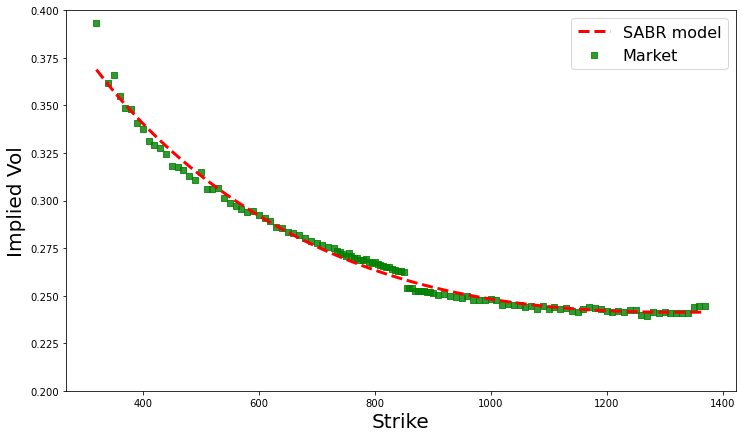

In [51]:
plt.figure(figsize = (12, 7))
plt.scatter(df['strike'],df['impliedvol'], alpha = 0.8, c = 'g' ,marker = 's', label = 'Market')
plt.plot(df['strike'], df['sabrsigma'], '--r', linewidth = 3, label = 'SABR model')
plt.ylabel('Implied Vol', fontsize = 20)
plt.xlabel('Strike', fontsize = 20)
plt.ylim(0.2, 0.4)
plt.legend(fontsize = 16);